<font size = 6>**Detect eye blinks using Pupil Labs' blink detection pipeline**

**<font size = 5>Part 1:** Offline blink detection

Let’s start by importing the relevant modules:

In [1]:
from blink_detector import blink_detection_pipeline
from blink_detector.helper import preprocess_recording
import numpy as np

Set the path to the example recording for analysis. Should you have your own recording, replace `recording_path` with the path to your recording.

In [2]:
recording_path = "blink_detector/data/padel_tennis_neon_03-2ded8f56"

The following cell extracts individual frames from the eye camera recording and applies some minor preprocessing:

In [3]:
left_eye_images, right_eye_images, ts = preprocess_recording(
    recording_path, is_neon=True
)

In order to detect eye blinks in the recording, we can now call 'blink_detection_pipeline'. We pass the extracted left and right eye video frames as well as the corresponding timestamps along and it outputs the detected blink events. Depending on your computational resources and the duration of the recording, this might take a short while.

In [4]:
blink_events = list(blink_detection_pipeline(left_eye_images, right_eye_images, ts))

Having extracted the detected blink events, we can now print a few interesting blink statistics:

In [5]:
print(
    f"Number of blinks: {len(blink_events)}"

    f"\nBlink rate [in Hz]: {len(blink_events) / ((ts[-1] - ts[0])/1e9):.2f}"

    f"\nAvg. blink duration [in sec]: {np.mean([blink.blink_duration_s for blink in blink_events]):.3f}"

    f"\nAvg. eyelid closing duration [in sec]: {np.mean([blink.eyelid_closing_duration_s for blink in blink_events]):.3f}"

    f"\nAvg. eyelid opening duration [in sec]: {np.mean([blink.eyelid_opening_duration_s for blink in blink_events]):.3f}"
)

Number of blinks: 61
Blink rate [in Hz]: 0.70
Avg. blink duration [in sec]: 0.265
Avg. eyelid closing duration [in sec]: 0.105
Avg. eyelid opening duration [in sec]: 0.154


As you see, it is fairly straightforward to apply the blink detection pipeline and extract a number of interesting parameters. You may have noticed while examining blink duration and the eyelid closing and re-opening times, that the total blink duration doesn't consistently equate to the sum of the durations of the closing and re-opening phases. This discrepancy occurs because there are some frames between eyelid closure and subsequent re-opening where the optical flow is effectively zero, so they don't contribute to either phase. However, blink duration is calculated from the start time of the eyelid closing to the last frame identified as part of the re-opening sequence. Therefore, blink duration will almost always be marginally longer than the sum of the individual events.<br>
To round off the first segment of this tutorial, we will present a visual representation of the detected blinks, providing some insights into their temporal distribution:

User-defined end_interval exceeds recording duration. Setting end_interval to 87.431279.


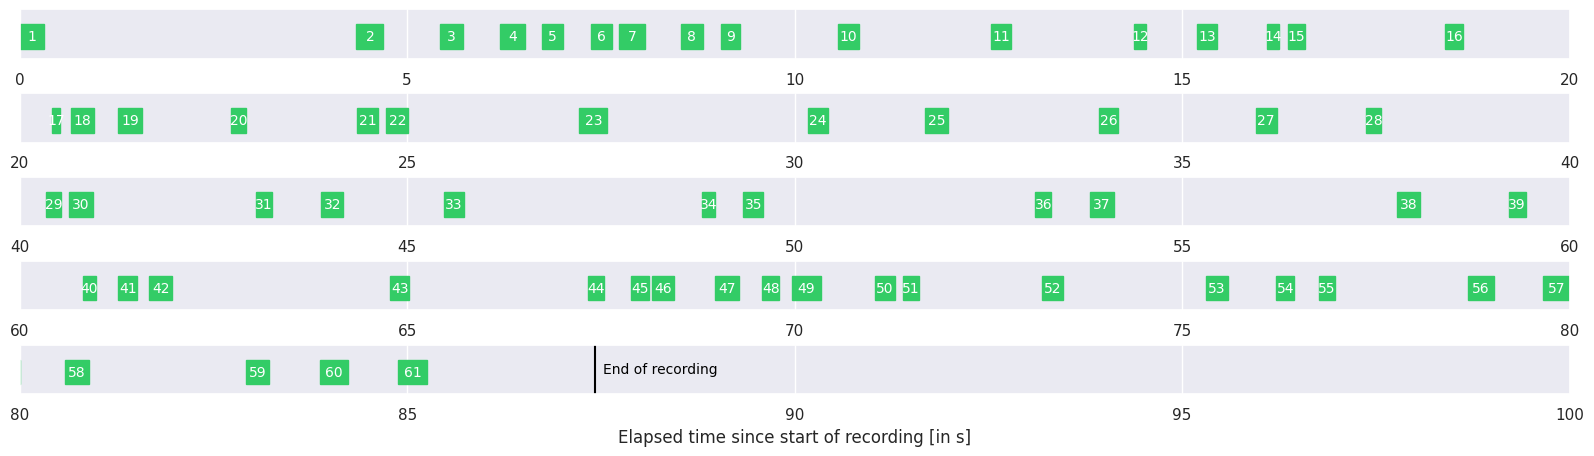

In [11]:
from blink_detector.helper import visualize_blink_events

# Limit the visualization to the first 100 s 
start_interval = 0
end_interval = 100

visualize_blink_events(blink_events, ts, start_interval, end_interval)

Great, you have finished the first part of this tutorial! Next, we'll delve into using Pupil Lab's Realtime Python API to carry out blink detection in realtime.

# <font size=5> **Part 2:** Blink detection in real time using Pupil Lab's Realtime Python API</font>

As demonstrated in Part 1, applying the blink detection pipeline to pre-recorded data is quite easy. Moving forward, this next section of the tutorial will walk you through detecting eye blinks in near-realtime using Pupil Lab's Real Time API. Detecting eye blinks in realtime can be beneficial for tracking blink rate over time (potentially serving as a fatigue biomarker) or even leveraging specific blink patterns to control external devices. For instance, in the upcoming sections, we'll walk you through the process of remotely starting and stopping recordings with your Neon or Pupil Invisible device by executing a rapid sequence of three eye blinks.

Note that the temporal resolution of the blink detection is inherently limited by some of the (post-)processing parameters outlined in the [white paper](https://docs.google.com/document/d/1JLBhC7fmBr6BR59IT3cWgYyqiaM8HLpFxv5KImrN-qE/export?format=pdf). Moreover, the demands of the image processing can further impede performance. Consequently, there will be an inherent delay in blink detection, which makes it *near*-realtime rather than truly realtime.

After you have successfully set up your environment, let’s first import all the required modules:

In [1]:
import nest_asyncio
import numpy as np
from pupil_labs.realtime_api.simple import discover_one_device, discover_devices
from blink_detector.blink_detector import blink_detection_pipeline
from blink_detector.helper import (
    stream_images_and_timestamps,
    update_array,
    compute_blink_rate,
    plot_blink_rate,
)

Next, we need to setup the real time API. We use Python's *asyncio* to implement asynchronous communication. In some environments, for example when working with Jupyter notebooks, asyncio won't work out of the box. We will make use of *nest_asyncio*, which allows *asyncio* to work also within Jupyter notebooks. 

In [2]:
nest_asyncio.apply()

In [ ]:
device = discover_one_device()
# if you have more than one device
# devices = discover_devices(10)

Printing the device name and its IP helps to make sure that the discovered device is indeed <br>
the device you would like to connect with.

In [4]:
print(f"Phone IP address: {device.phone_ip}")
print(f"Phone name: {device.phone_name}")

Phone IP address: 192.168.20.131
Phone name: Neon Companion Tom


Start and end Neon recording with 3 blinks in quick succession. Send event message to Neon with 3 blinks in quick succession.

In [ ]:
import time
from collections import deque

device_is_recording = False

left_images, right_images, timestamps = stream_images_and_timestamps(
    device, is_neon=True
)

# initialize a deque with N zeros (N: number of successive blinks)
blink_queue = deque(maxlen=3)
blink_queue.extend(np.zeros(3))

# time interval within which the N blinks must occur
time_interval = 1.0

blink_event_stream = blink_detection_pipeline(left_images, right_images, timestamps)

while True:
    
    blink_event = next(blink_event_stream)

    blink_queue.append(blink_event.start_time / 1e9)

    toggle_recording = blink_queue[-1] - blink_queue[0] < time_interval

    if toggle_recording:
        if device_is_recording:
            if time.time() - start_of_recording < 0.5:
                print("Time between start and stop of recording is too short.")
                time.sleep(0.5)
            print("Stop recording")
            device.recording_cancel()
            device_is_recording = False
        else:
            print("Start recording")
            device.recording_start()
            device_is_recording = True
            start_of_recording = time.time()
            
        toggle_recording = False

**Real-time blink rate since start of recording and over the last 30s**

In this last part of the Alpha Lab, we will show you how to utilize the Realtime API in combination with the blink detection pipeline in order to perform realtime blink-rate estimation.
**Limitation:** As the blink detection pipeline is a generator object, it will block execution of the code until a blink event is yielded. This means that any computation that is carried out within the for-loop will only execute once a blink occurs. This means that blink rate can only be updated once a blink is detected.

In [ ]:
# we need to re-initialize the streams as the previous ones have been exhausted
left_images, right_images, timestamps = stream_images_and_timestamps(
    device, is_neon=True
)

import time

# let's keep track of the last 100 blinks
blink_times = np.zeros(100)
blink_rate_tot = np.zeros(100)
blink_rate_30s = np.zeros(100)

blink_counter = 0
starting_time = time.time()

while True:

    blink_event = next(blink_detection_pipeline(left_images, right_images, timestamps))
    
    blink_counter += 1

    elapsed_time = blink_event.start_time / 1e9 - starting_time

    blink_times = update_array(blink_times, elapsed_time)

    blink_rate_tot = update_array(
        blink_rate_tot, compute_blink_rate(blink_counter, elapsed_time)
    )

    blink_counter_last_30s = np.sum(blink_times > max(blink_times[0] - 30, 0))

    blink_rate_30s = update_array(
        blink_rate_30s, blink_counter_last_30s / min(30, blink_times[0])
    )

    plot_blink_rate(blink_times, blink_rate_tot, blink_rate_30s)